<a href="https://colab.research.google.com/github/lazysimon/NYCDSA_CapstoneProject/blob/master/als_revised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Spark (2.4.4) and findspark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

spark-2.4.4-bin-hadoop2.7/
spark-2.4.4-bin-hadoop2.7/R/
spark-2.4.4-bin-hadoop2.7/R/lib/
spark-2.4.4-bin-hadoop2.7/R/lib/sparkr.zip
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/R.css
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/html/00Index.html
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/aliases.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/AnIndex
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdx
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/SparkR.rdb
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/help/paths.rds
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-2.4.4-bin-hadoop2.7/R/lib/SparkR/tests/testthat/te

# Importing Neccessary Packages

In [0]:
# time
import time

# os 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# data science imports
import math
import numpy as np
import pandas as pd


#from scipy.sparse import csr_matrix
#from urllib.request import urlopen

# utils import
#!pip install fuzzywuzzy
#from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import findspark
findspark.init()

from pyspark import SparkContext

# import pyspark.sql related packages
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.functions import UserDefinedFunction, explode, desc, col, lower, lit
from pyspark.sql.types import StringType, ArrayType

# import pyspark.ml related packages
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.master("local[*]")\
.appName("movie_recommender")\
.config("spark.sql.crossJoin.enabled", "true").getOrCreate()

%matplotlib inline

In [0]:
# spark config
# spark = SparkSession \
#     .builder \
#     .appName("movie recommendation") \
#     .config("spark.driver.maxResultSize", "96g") \
#     .config("spark.driver.memory", "96g") \
#     .config("spark.executor.memory", "8g") \
#     .config("spark.master", "local[12]") \
#     .getOrCreate()
# get spark context
# sc = spark.sparkContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
# mergeSQL = sqlContext.createDataFrame(mergeDF)

In [45]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


# Loading the Datasets

In [46]:
### loading the movie dataset
movie_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/movies.dat'
movieDF = pd.read_csv(movie_fname, sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
movieDF = movieDF.drop('Genres', 1)

### loading the rating dataset
rating_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/ratings.dat'
ratingDF = pd.read_csv(rating_fname, sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
ratingDF = ratingDF.drop('Timestamp',1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [5]:
### print the first five rows of the two datasets
print(movieDF.head(5))
print(ratingDF.head(5))

   MovieId                                        Movie_Title
0        8      Edison Kinetoscopic Record of a Sneeze (1894)
1       10                La sortie des usines Lumière (1895)
2       12                      The Arrival of a Train (1896)
3       25  The Oxford and Cambridge University Boat Race ...
4       91                         Le manoir du diable (1896)
   UserId  MovieId  Rating
0       1   111161      10
1       1   117060       7
2       1   120755       6
3       1   317919       6
4       1   454876      10


In [0]:
### convert the dataframes to spark.RDD
ratingRDD = sqlContext.createDataFrame(ratingDF)
ratingRDD = ratingRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")

movieRDD = sqlContext.createDataFrame(movieDF)
movieRDD = movieRDD.selectExpr("MovieId as item","Movie_title as title")

In [9]:
print("Number of movies: {}".format(movieRDD.count()))
print("Number of ratings: {}".format(ratingRDD.count()))
print("Number of users: {}".format(ratingRDD.select('user').distinct().count()))

Number of movies: 34000
Number of ratings: 801291
Number of users: 59168


In [10]:
### print the first five rows of the two RDDs
print(ratingRDD.show())
print(movieRDD.show())

+----+-------+------+
|user|   item|rating|
+----+-------+------+
|   1| 111161|    10|
|   1| 117060|     7|
|   1| 120755|     6|
|   1| 317919|     6|
|   1| 454876|    10|
|   1| 790724|     8|
|   1| 882977|     8|
|   1|1229238|     9|
|   1|1288558|     5|
|   1|1300854|     8|
|   1|1483013|     6|
|   1|1583421|     7|
|   1|1588173|     9|
|   1|1711425|     3|
|   1|2024432|     8|
|   1|2053463|     8|
|   1|2101341|     7|
|   1|2101441|     1|
|   1|2302755|    10|
|   2| 422720|     8|
+----+-------+------+
only showing top 20 rows

None
+----+--------------------+
|item|               title|
+----+--------------------+
|   8|Edison Kinetoscop...|
|  10|La sortie des usi...|
|  12|The Arrival of a ...|
|  25|The Oxford and Ca...|
|  91|Le manoir du diab...|
| 131|Une nuit terrible...|
| 417|Le voyage dans la...|
| 439|The Great Train R...|
| 443|Hiawatha, the Mes...|
| 628|The Adventures of...|
| 833|The Country Docto...|
|1223| Frankenstein (1910)|
|1740|The Lonedale Op

# Study user behaviours


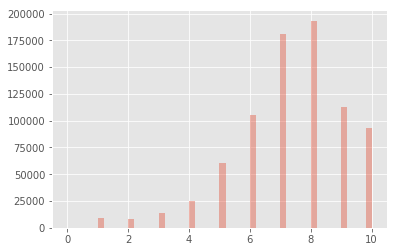

In [0]:
import seaborn as sns

r = ratingRDD.select('rating').collect()
sns.distplot(r, kde=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


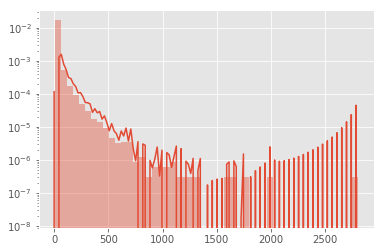

In [0]:
ratings_per_user = ratingRDD.groupBy("user").count()
sns.distplot(ratings_per_user.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (1.0, 3000.0)})  # a gaussian kernel density

In [0]:
# study the super users who rated more than 1000 movies
ratings_per_user.filter(col('count') > 1000).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|        14|
+----------+



In [0]:
# study the users who rated less than 2 ratings
ratings_per_user.filter(col('count') < 2).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|     26094|
+----------+



# Study item behaviors

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


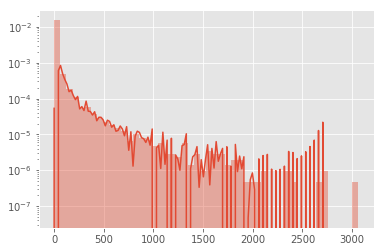

In [0]:
ratings_per_movie = ratingRDD.groupBy("item").count()
sns.distplot(ratings_per_movie.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (0, 3000.0)}) # a gaussian kernel density

In [0]:
# movies with less than 2 ratings
ratings_per_movie.filter(col('count') < 2).groupBy('item').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|     14300|
+----------+



In [0]:
### user defined functions
def split_sets(ratings, proportions):
  '''
  input: the dataset and the proportion list
  output: the split datasets
  '''
  split = ratings.randomSplit(proportions, seed=42)
  return {'training': split[0], 'validation': split[1], 'test': split[2]}
  
def calc_se(rating, user_factor, item_factor):
  '''
  Squared Error (SE) for a single rating and prediction
  '''
  prediction = user_factor.T.dot(item_factor)
  return (rating - prediction) ** 2

In [49]:
### split the dataset into training, validation and test datasets
sets = split_sets(ratingRDD, [0.60, 0.20, 0.20])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 480516
Validation dataset size = 160919
Test dataset size = 159856


In [50]:
sets['training'].show(10)

+----+-------+------+
|user|   item|rating|
+----+-------+------+
|   1| 454876|    10|
|   1| 790724|     8|
|   1| 882977|     8|
|   1|1229238|     9|
|   1|1288558|     5|
|   1|1483013|     6|
|   1|1583421|     7|
|   1|1588173|     9|
|   1|2024432|     8|
|   1|2053463|     8|
+----+-------+------+
only showing top 10 rows



# Parameter tuning

In [51]:
### Parameter tuning
als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8]) \
    .addGrid(als.maxIter,[8, 10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

%time model = tvs.fit(sets['training'])

print("Best rank = {}".format(model.bestModel.rank))
print("Best maxIter = {}".format(model.bestModel._java_obj.parent().getMaxIter()))

CPU times: user 964 ms, sys: 186 ms, total: 1.15 s
Wall time: 1min 51s
Best rank = 6
Best maxIter = 12


In [0]:
# model.save('./model1')
from pyspark.ml.recommendation import ALS, ALSModel
!rm -rf ./model1
best_model = model.bestModel
best_model.write().overwrite().save('/content/gdrive/My Drive/model1')
model1 = ALSModel.load('/content/gdrive/My Drive/model1')

In [81]:
prediction = model.transform(sets['test'])
# movieRDD = movieRDD.selectExpr("UserId as user","MovieId as item","Rating as rating")

prediction.alias('p').join(movieRDD.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

+-----+--------------------------------------+----------+------+
|user |title                                 |prediction|rating|
+-----+--------------------------------------+----------+------+
|21563|Only Angels Have Wings (1939)         |8.29435   |9     |
|41579|The Lost Weekend (1945)               |5.9688463 |9     |
|27802|The Lost Weekend (1945)               |7.144382  |8     |
|30478|The Lost Weekend (1945)               |9.034233  |9     |
|10957|The Lost Weekend (1945)               |8.47364   |9     |
|10478|The Lost Weekend (1945)               |8.494844  |9     |
|41281|Lady and the Tramp (1955)             |6.2481766 |7     |
|3833 |Lady and the Tramp (1955)             |7.6337767 |9     |
|58043|Lady and the Tramp (1955)             |7.513061  |7     |
|40048|Lady and the Tramp (1955)             |7.4415536 |9     |
|37987|Lady and the Tramp (1955)             |7.7848406 |3     |
|17310|Lady and the Tramp (1955)             |7.3022175 |8     |
|36036|Lady and the Tramp

In [78]:
prediction2 =model1.transform(sets['test'])
prediction2.alias('p').join(movieRDD.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

+-----+--------------------------------------+----------+------+
|user |title                                 |prediction|rating|
+-----+--------------------------------------+----------+------+
|21563|Only Angels Have Wings (1939)         |8.29435   |9     |
|10478|The Lost Weekend (1945)               |8.494844  |9     |
|10957|The Lost Weekend (1945)               |8.47364   |9     |
|27802|The Lost Weekend (1945)               |7.144382  |8     |
|30478|The Lost Weekend (1945)               |9.034233  |9     |
|41579|The Lost Weekend (1945)               |5.9688463 |9     |
|3833 |Lady and the Tramp (1955)             |7.6337767 |9     |
|17310|Lady and the Tramp (1955)             |7.3022175 |8     |
|36036|Lady and the Tramp (1955)             |7.100694  |8     |
|37987|Lady and the Tramp (1955)             |7.7848406 |3     |
|40048|Lady and the Tramp (1955)             |7.4415536 |9     |
|41281|Lady and the Tramp (1955)             |6.2481766 |7     |
|58043|Lady and the Tramp

(0, 10)

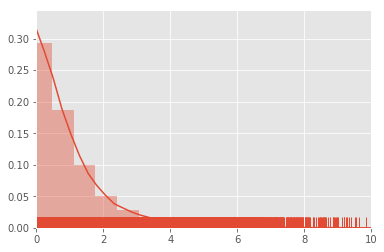

In [0]:
# plot the errors
errors = prediction.withColumn('error', col('prediction')-col('rating')).select('error').collect()
ax = sns.distplot(errors, rug=True, hist=True)
ax.set_xlim(0, 10)

In [84]:
mse = evaluator.evaluate(prediction)
print("MSE = {}".format(mse))

MSE = 2.7036853416141065


In [83]:
mse = evaluator.evaluate(prediction2)
print("MSE ={}".format(mse))

MSE =2.703685341614325


In [0]:
# top 10 movies for all users
k = 10 
model.bestModel.recommendForAllUsers(k).show(10)

KeyboardInterrupt: ignored

In [0]:
# top 10 users for all movies
model.bestModel.recommendForAllItems(k).show(10)

In [0]:
user59169 = ratingRDD.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(user59169)) # 59168 users

New user id = 59169


In [0]:
# string matching function to find the movieID
def find_movie_id(partial_title):
    movieRDD.where(lower(col('title')).like("%{}%".format(partial_title.lower())))\
    .show(truncate=False)

In [0]:
print(find_movie_id('Express'))

+-------+-----------------------------------+
|item   |title                              |
+-------+-----------------------------------+
|23333  |The Phantom Express (1932)         |
|23458  |Shanghai Express (1932)            |
|59885  |Von Ryan's Express (1965)          |
|61715  |De Dwerg-Express (1967)            |
|68713  |Horror Express (1972)              |
|69291  |Snowball Express (1972)            |
|71877  |Murder on the Orient Express (1974)|
|72226  |The Sugarland Express (1974)       |
|77928  |Midnight Express (1978)            |
|91819  |Il ragazzo del pony express (1986) |
|338348 |The Polar Express (2004)           |
|372279 |Festival Express (2003)            |
|469903 |The Express (2008)                 |
|910936 |Pineapple Express (2008)           |
|2112124|Chennai Express (2013)             |
|2316465|Big Easy Express (2012)            |
|2973132|Sun Belt Express (2014)            |
|3402236|Murder on the Orient Express (2017)|
+-------+-------------------------

In [0]:
# ### marvel movies enthusiast who hates romance movies
# rating59169 = [
#     (118661, 9), # Avengers
#     (371746, 9),  # Iron Man 2008
#     (94625, 9),  # Akira
#     (1563738, 2), # One day 2011
#     (800369, 8),  # Thor
#     (1981115, 9), # Thor: The Dark World
#     (3501632, 9), # Thor: Ragnarok
#     (120338, 3), # Titanic
#     (98635, 2), # When Harry Met Sally
#     (125439, 3), # Notting Hill
#     (332280, 1) # The Notebook
# ]
# user59169DF = spark.createDataFrame([Row(user=user59169, item=r[0], rating=r[1]) for r in rating59169])
# user59169DF.show()


############## recommended results ##################################
# |59169|Man of Steel (2013)                             |9.824976  |
# |59169|Pacific Rim (2013)                              |9.236132  |
# |59169|It (2017)                                       |9.141861  |
# |59169|American Sniper (2014)                          |8.863254  |
# |59169|John Wick (2014)                                |8.706167  |
# |59169|Avengers: Age of Ultron (2015)                  |8.14641   |
# |59169|Furious 7 (2015)                                |8.096879  |
# |59169|Star Wars: The Force Awakens (2015)             |7.9387665 |
# |59169|Batman v Superman: Dawn of Justice (2016)       |7.867798  |
# |59169|Once Upon a Time ... in Hollywood (2019)        |7.829237  |
# |59169|Argo (2012)                                     |7.5842814 |
# |59169|Godzilla (2014)                                 |7.550987  |

+-------+------+-----+
|   item|rating| user|
+-------+------+-----+
| 118661|     9|59169|
| 371746|     9|59169|
|  94625|     9|59169|
|1563738|     2|59169|
| 800369|     8|59169|
|1981115|     9|59169|
|3501632|     9|59169|
| 120338|     3|59169|
|  98635|     2|59169|
| 125439|     3|59169|
| 332280|     1|59169|
+-------+------+-----+



In [0]:
### romance movie addict who hates marvel movies
rating59169 = [
    (118661, 1), # Avengers
    (371746, 1),  # Iron Man 2008
    (1563738, 9), # One day 2011
    (800369, 1),  # Thor
    (1981115, 2),  # Thor: The Dark World
    (3501632, 2),  # Thor: Ragnarok
    (120338, 9), # Titanic
    (98635, 9), # When Harry Met Sally
    (125439, 9), # Notting Hill
    (332280, 9) # The Notebook
]
user59169DF = spark.createDataFrame([Row(user=user59169, item=r[0], rating=r[1]) for r in rating59169])
user59169DF.show()

############## recommended results ##################################
# |59169|Boyhood (2014)                                  |10.516007  |
# |59169|Birdman (2014)                                  |9.3878355  |
# |59169|The Great Gatsby (2013)                         |8.219972   |
# |59169|Lucy (2014)                                     |7.9128814  |
# |59169|Gone Girl (2014)                                |7.764477   |
# |59169|Room (2015)                                     |7.613449   |
# |59169|Manchester by the Sea (2016)                    |7.5043364  |
# |59169|La La Land (2016)                               |7.1786413  |
# |59169|The Hunger Games: Catching Fire (2013)          |7.065142   |
# |59169|Baby Driver (2017)                              |7.051465   |
# |59169|The Revenant (2015)                             |6.954708   |
# |59169|12 Years a Slave (2013)                         |6.8128624  |
# |59169|The Theory of Everything (2014)                 |6.762633   |

+-------+------+-----+
|   item|rating| user|
+-------+------+-----+
| 118661|     1|59169|
| 371746|     1|59169|
|1563738|     9|59169|
| 800369|     1|59169|
|1981115|     2|59169|
|3501632|     2|59169|
| 120338|     9|59169|
|  98635|     9|59169|
| 125439|     9|59169|
| 332280|     9|59169|
+-------+------+-----+



In [0]:
user59169DF = user59169DF.select('user','item','rating')
# user59169DF.show()
type(user59169DF)

pyspark.sql.dataframe.DataFrame

In [0]:
ratingRDD2 = ratingRDD.union(user59169DF)
ratingRDD2.groupBy().max('user').first()['max(user)'] + 1
user59170 = ratingRDD2.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(user59170)) # 59170 users

New user id = 59170


In [0]:
# get the best model parameters
best_rank = model.bestModel.rank
best_iterations = model.bestModel._java_obj.parent().getMaxIter()

# fit the model with the newly appended dataset
%time new_model = ALS(rank=best_rank, maxIter=best_iterations, coldStartStrategy="drop").fit(ratingRDD2)

CPU times: user 65.8 ms, sys: 9.12 ms, total: 74.9 ms
Wall time: 12.2 s


In [0]:
unseen_movies = movieRDD.alias('m').join(user59169DF.alias('r'), col('m.item') == col('r.item'), how='left_anti').select('item')
#unseen_movies.show(10)
print("Number of unseen movies = {}".format(unseen_movies.count()))

Number of unseen movies = 33990


In [0]:
unseen_movies_user = unseen_movies.withColumn("user", lit(user59169))
unseen_movies_user.show()

+-----+-----+
| item| user|
+-----+-----+
| 9968|59169|
|31762|59169|
|37098|59169|
|37884|59169|
|38108|59169|
|38510|59169|
|48280|59169|
|49967|59169|
|51418|59169|
|54415|59169|
|61135|59169|
|61597|59169|
|64757|59169|
|64873|59169|
|65462|59169|
|65848|59169|
|66070|59169|
|66580|59169|
|67148|59169|
|69976|59169|
+-----+-----+
only showing top 20 rows



In [0]:
unseen_movies.show()

+-----+
| item|
+-----+
| 9968|
|31762|
|37098|
|37884|
|38108|
|38510|
|48280|
|49967|
|51418|
|54415|
|61135|
|61597|
|64757|
|64873|
|65462|
|65848|
|66070|
|66580|
|67148|
|69976|
+-----+
only showing top 20 rows



In [0]:
spark.conf.set("spark.sql.crossJoin.enabled", "true")
unseen_ratings = new_model.transform(unseen_movies_user)
unseen_ratings.show(10)

+-----+-----+----------+
| item| user|prediction|
+-----+-----+----------+
|  833|59169| 2.8973012|
| 4101|59169| 4.8336797|
| 7880|59169| 5.0066476|
|18051|59169|  7.591892|
|19079|59169|  2.159605|
|25591|59169|   5.15475|
|31951|59169|  5.026424|
|31983|59169|  4.257686|
|33717|59169|0.07343292|
|40335|59169|  8.512117|
+-----+-----+----------+
only showing top 10 rows



In [0]:
unseen_ratings_titles = unseen_ratings.alias('r')\
                        .join(movieRDD.alias('m'), col('r.item') == col('m.item'))\
                        .select(['user', 'title', 'prediction'])


unseen_ratings_titles.show(10, truncate=False) ##lmao exceeds max rating

+-----+-----------------------------------------------------+------------+
|user |title                                                |prediction  |
+-----+-----------------------------------------------------+------------+
|59169|Broken Blossoms or The Yellow Man and the Girl (1919)|6.8532057   |
|59169|Only Angels Have Wings (1939)                        |6.8404922   |
|59169|The Mummy's Curse (1944)                             |1.7276839   |
|59169|The Lost Weekend (1945)                              |8.512746    |
|59169|The Spanish Main (1945)                              |0.36350465  |
|59169|Enamorada (1946)                                     |5.5077343   |
|59169|Lady and the Tramp (1955)                            |9.485463    |
|59169|X: The Unknown (1956)                                |-0.059227467|
|59169|The Blob (1958)                                      |3.8429134   |
|59169|12 to the Moon (1960)                                |0.48627552  |
+-----+------------------

In [0]:
unseen_ratings_titles.orderBy(col('prediction').desc()).show(20)

+-----+--------------------+----------+
| user|               title|prediction|
+-----+--------------------+----------+
|59169|Love After Sunris...|  21.40348|
|59169|Meitantei Conan: ...| 19.810555|
|59169|   Loose Ends (1975)| 19.454693|
|59169|American Weightli...| 19.428257|
|59169|      Dukhtar (2014)| 18.945087|
|59169|  Documenteur (1981)|  18.86004|
|59169|       Kapila (2014)| 18.809505|
|59169| King's Faith (2013)| 18.542048|
|59169|Jattu Engineer (2...| 18.402168|
|59169|    Ohikkoshi (1993)| 18.058807|
|59169|      Nowhere (1997)| 18.055805|
|59169|Nishwartha Bhalob...| 17.693596|
|59169|I Am Trying to Br...| 17.370785|
|59169|The Argon Quest (...|  17.00871|
|59169|    Groundhog (2017)| 16.436878|
|59169|The Tree Widow (2...| 16.197392|
|59169|Fairuz, we hielde...| 16.052273|
|59169|     Material (2012)| 15.999176|
|59169|    Mr. Fraud (2014)| 15.861296|
|59169|Dil Hai Tumhaara ...| 15.776266|
+-----+--------------------+----------+
only showing top 20 rows



In [0]:
ratings_per_movie = ratingRDD.groupBy('item').count()
enough_ratings = ratings_per_movie.filter(col('count') < 1000)
enough_ratings.show()

+-------+-----+
|   item|count|
+-------+-----+
|1972571|  377|
|  97216|   71|
|1360860|  132|
| 796366|  321|
|1477834|  742|
|3967856|  284|
|1640711|   16|
| 803096|  510|
|5177088|   68|
|1600524|   34|
|3174376|   84|
|1772264|  103|
|3658772|   45|
|1131734|   48|
| 462335|   93|
|5112966|    1|
|4005402|  187|
|1259528|  211|
|1243974|  137|
|1028576|   13|
+-------+-----+
only showing top 20 rows



In [0]:
training_100 = unseen_ratings.alias('r')\
    .join(enough_ratings.alias('e'), col('r.item') == col('e.item'), how='left_anti')\
    .select(['item', 'user', 'prediction']).orderBy(col('prediction').desc())
training_100.show()

+-------+-----+----------+
|   item| user|prediction|
+-------+-----+----------+
|1065073|59169| 10.516007|
|2562232|59169| 9.3878355|
|1343092|59169|  8.219972|
|2872732|59169| 7.9128814|
|2267998|59169|  7.764477|
|3170832|59169|  7.613449|
|4034228|59169| 7.5043364|
|3783958|59169| 7.1786413|
|1951264|59169|  7.065142|
|3890160|59169|  7.051465|
|1663202|59169|  6.954708|
|2024544|59169| 6.8128624|
|2980516|59169|  6.762633|
|2872718|59169|  6.741751|
|2084970|59169| 6.7360473|
|3460252|59169|  6.681568|
|2278388|59169| 6.5829997|
| 359950|59169| 6.5399833|
|1392190|59169| 6.4531856|
|1392214|59169| 6.4254847|
+-------+-----+----------+
only showing top 20 rows



In [0]:
training_100.alias('t').join(movieRDD.alias('m'), col('t.item') == col('m.item')) \
    .select(['user', 'title', 'prediction']).orderBy(col('prediction').desc()).show(100, truncate=False)

+-----+------------------------------------------------+-----------+
|user |title                                           |prediction |
+-----+------------------------------------------------+-----------+
|59169|Boyhood (2014)                                  |10.516007  |
|59169|Birdman (2014)                                  |9.3878355  |
|59169|The Great Gatsby (2013)                         |8.219972   |
|59169|Lucy (2014)                                     |7.9128814  |
|59169|Gone Girl (2014)                                |7.764477   |
|59169|Room (2015)                                     |7.613449   |
|59169|Manchester by the Sea (2016)                    |7.5043364  |
|59169|La La Land (2016)                               |7.1786413  |
|59169|The Hunger Games: Catching Fire (2013)          |7.065142   |
|59169|Baby Driver (2017)                              |7.051465   |
|59169|The Revenant (2015)                             |6.954708   |
|59169|12 Years a Slave (2013)    